<a href="https://colab.research.google.com/github/plaban1981/Vision_Transformer_Model/blob/main/Vision_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement : Tomato leaf disease detection

## Build Montages

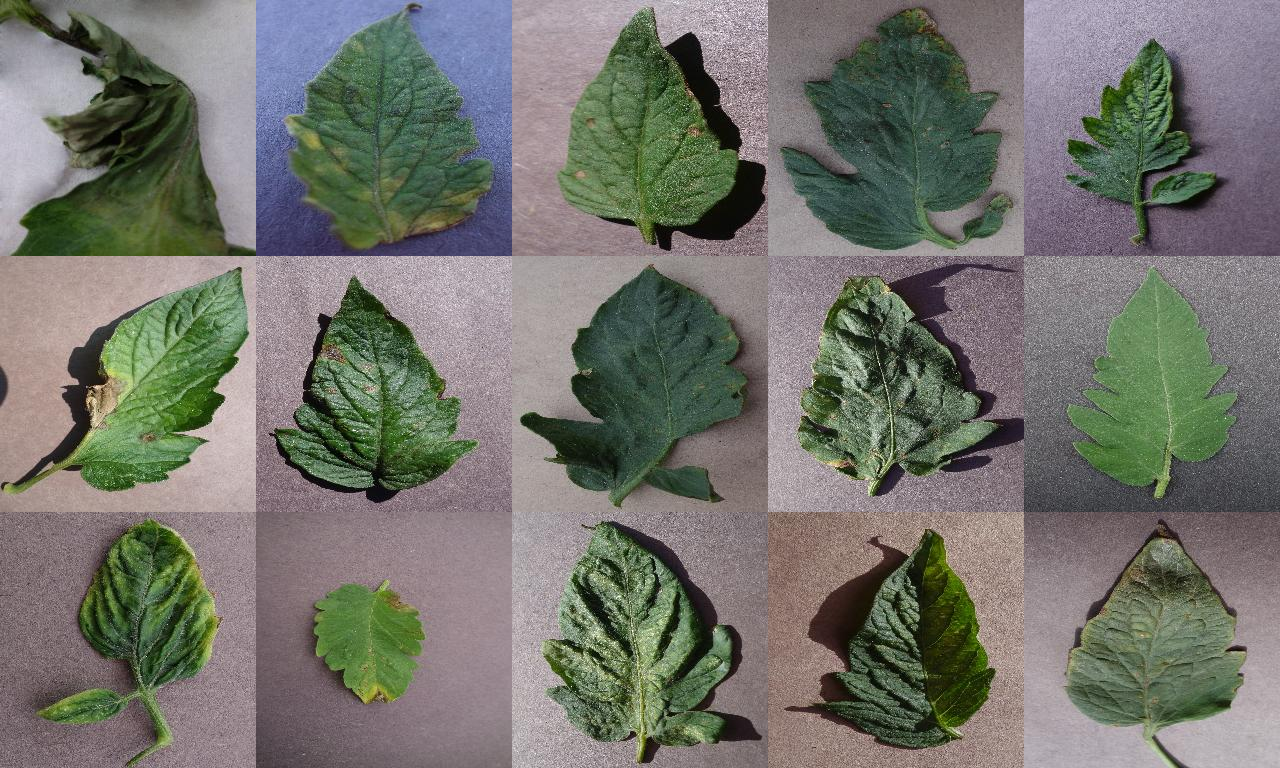

In [251]:
# import the necessary packages
from imutils import build_montages
from imutils import paths
import argparse
import random
import cv2
# grab the paths to the images, then randomly select a sample of
# them
args = {"images":"/content/drive/MyDrive/Tomato/tomato/test","sample":15}
imagePaths = list(paths.list_images(args["images"]))
random.shuffle(imagePaths)
imagePaths = imagePaths[:args["sample"]]
# initialize the list of images
images = []
# loop over the list of image paths
for imagePath in imagePaths:
	# load the image and update the list of images
	image = cv2.imread(imagePath)
	images.append(image)
# construct the montages for the images
montages = build_montages(images, (256,256), (5, 3))
# loop over the montages and display each of them
for montage in montages:
	cv2_imshow(montage)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


1) ! pip install -q kaggle.

2) from google.colab import files. files.upload() 

3) ! mkdir ~/.kaggle

4) ! cp kaggle.json ~/.kaggle/ 

5) ! chmod 600 ~/.kaggle/kaggle.json. 

6) ! kaggle datasets list. 

7)! kaggle competitions 
download -c 'name-of-competition'

In [4]:
%%capture
!pip install --upgrade kaggle 

In [5]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"d61acf0f28316eb769f6277166dc52bd"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-15 08:36:45           5229  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2904  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            327  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1756  
imsparsh/musicnet-dataset                                   MusicNet Dataset

In [9]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

 91% 162M/179M [00:06<00:00, 20.7MB/s]
100% 179M/179M [00:06<00:00, 28.6MB/s]


## Unzip the data anbd store it in google drive

In [10]:
!unzip -qq "/content/tomatoleaf.zip" -d "/content/drive/MyDrive/Tomato"

## Libraries and Configurations

In [12]:
%%capture
!pip install tensorflow_addons

In [14]:
%%capture
!pip install vit-keras

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import os
import shutil
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [18]:
labels = os.listdir("/content/drive/MyDrive/Tomato/tomato/train")
labels 

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [65]:
len(labels)

10

In [26]:
import numpy as np
src = os.listdir("/content/drive/MyDrive/Tomato/tomato/val/Tomato___Tomato_mosaic_virus/")
for i in range(np.random.randint(0,5)):
  print(i)
  print(src[i])

0
000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG
1
00c07a77-15e6-4815-92d4-8d1e1afb7f3c___PSU_CG 2052.JPG


##Visualize Actual Image Size

In [193]:
import cv2
image =  cv2.imread("/content/drive/MyDrive/Tomato/tomato/val/Tomato___Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG")
image.shape

(256, 256, 3)

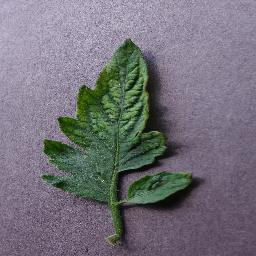

In [195]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

## Creating Test Data

In [27]:
for label in os.listdir("/content/drive/MyDrive/Tomato/tomato/val"):
  path = "/content/drive/MyDrive/Tomato/tomato/val/"+ label+"/"
  src = os.listdir(path)
  for i in range(np.random.randint(0,5)):
    src_file = path + src[i]
    shutil.copy(src_file,"/content/drive/MyDrive/Tomato/tomato/test")


## Seting parameters

In [196]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10

## Setting Path Varibales

In [68]:
TRAIN_PATH = '/content/drive/MyDrive/Tomato/tomato/train'
VALID_PATH = '/content/drive/MyDrive/Tomato/tomato/val'
TEST_PATH = '/content/drive/MyDrive/Tomato/tomato/test/'


## Data Augmentations

In [31]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Data Generator

* Keras generator alway looks for subfolders (representing the classes). Images insight the subfolders are associated with a class.

*  The data generator will only look for images in subfolders 

* Each subfolder in the images folder is interpreted as one class by the generator

#### There could be two situations when you run ImageDataGenerator on test set of images.

* Case #1: Test folder has subfolders representing the classes. 

* Case #2: There are no labelled test images. In this case, you will have a single test folder which contains all the images that you want to classify.

In [36]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

In [37]:
datagen

The flow_from_directory function is particularly helpful as it allows to load batches of images from a labeled directory structure, where the name of each subdirectory is the class name for a classification task.

In [197]:
train_gen = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    class_mode="categorical",
    seed=42
)

Found 10000 images belonging to 10 classes.


In [198]:
valid_gen = datagen.flow_from_directory(
    directory = VALID_PATH,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    class_mode="categorical",
    seed=42
)

Found 1000 images belonging to 10 classes.


In [199]:
len(os.listdir(VALID_PATH))

10

**A test directory which doesn’t have subdirectories as you don’t know the classes of those images.**

 Inside of test is simply a variety of images of unknown class, and we can’t use the flow_from_directory function like we did above for train and validation as we’ll end up with the following issue:

 **""Found 0 images belonging to 0 classes.""**

There is a workaround to this however, as you can specify the parent directory of the test directory and specify that you only want to load the test “class”:

In [200]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [201]:
test_gen = datagen.flow_from_directory(
        "/content/drive/MyDrive/Tomato/tomato/",
        classes=['test'],
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 22 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


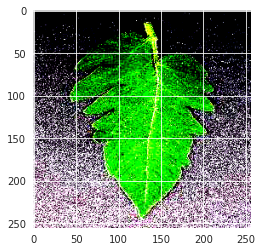

In [202]:
x = test_gen.next()
image = x[0]
plt.imshow(image[0])

##Visualize Training Data Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

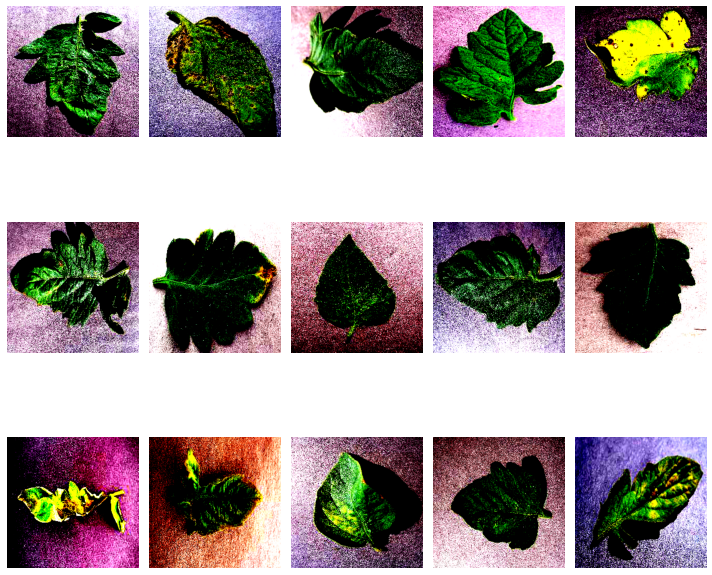

In [203]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

##Build Model

In [204]:
from vit_keras import vit

## 1. ViT B32 Model

In [206]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(labels))

## 2. Fine-tuning the Model

In [207]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(labels), 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87466752  
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 768)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 11)                8459      
_________________________________________________________________
batch_normalization_3 (Batch (None, 11)                44        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                120       
Total params: 87,478,447
Trainable params: 87,476,889
Non-trainable params: 1,558
________________________________

## Setting Model Hyperparameters and Callbacks

In [114]:
import keras.backend as K

def f1(y_true, y_pred): #taken from old keras source code
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [208]:
learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy',f1])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]


##Training the Model

In [209]:
model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)



Epoch 1/10
625/625 [==============================] - 168s 248ms/step - loss: 1.5159 - accuracy: 0.7126 - f1: 0.4894 - val_loss: 1.0425 - val_accuracy: 0.9425 - val_f1: 0.9198

Epoch 00001: val_accuracy improved from -inf to 0.94254, saving model to ./model.hdf5
Epoch 2/10
625/625 [==============================] - 153s 244ms/step - loss: 1.0493 - accuracy: 0.9577 - f1: 0.9123 - val_loss: 0.9574 - val_accuracy: 0.9718 - val_f1: 0.9653

Epoch 00002: val_accuracy improved from 0.94254 to 0.97177, saving model to ./model.hdf5
Epoch 3/10
625/625 [==============================] - 154s 246ms/step - loss: 0.9856 - accuracy: 0.9724 - f1: 0.9587 - val_loss: 1.0001 - val_accuracy: 0.9425 - val_f1: 0.9354

Epoch 00003: val_accuracy did not improve from 0.97177
Epoch 4/10
625/625 [==============================] - 153s 245ms/step - loss: 0.9606 - accuracy: 0.9744 - f1: 0.9680 - val_loss: 0.9463 - val_accuracy: 0.9657 - val_f1: 0.9652

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.999

## Training Accuracy Vs Validation Accuracy

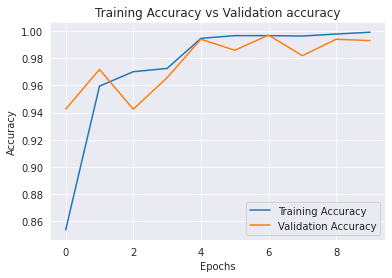

In [210]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

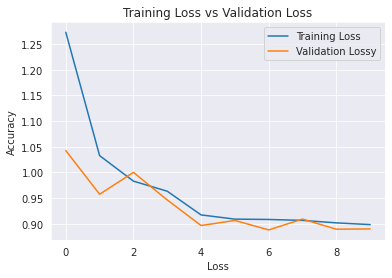

In [211]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Lossy')
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.show()

## Save the Model

In [122]:
best_model = model.load_weights("/content/model.hdf5")

In [212]:
loss,accuracy,f1_score = model.evaluate(valid_gen)

63/63 [==============================] - 11s 176ms/step - loss: 0.8870 - accuracy: 0.9960 - f1: 0.9960


In [213]:
print(f"Evaluation scores of the model Loss:{loss} , Accuracy Score :{accuracy}, F1 Score :{f1_score}")

Evaluation scores of the model Loss:0.8870095610618591 , Accuracy Score :0.9959999918937683, F1 Score :0.9960317611694336


## Save Model

In [214]:
model.save('Tomato_model.h5')

In [220]:
from keras.models import load_model
best_model = load_model('Tomato_model.h5')

ValueError: ignored

In [218]:
best_model.summary()

AttributeError: ignored

##Visualizing Attention Maps of Sample Test Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


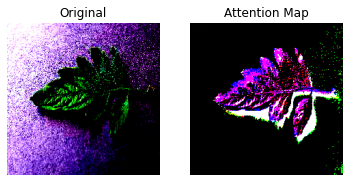

In [95]:
from vit_keras import visualize
x = test_gen.next()
image = x[0][0]
print
attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## Make Predictions on test data 

In [221]:
preds = model.predict(test_gen)

In [222]:
predictions = [np.argmax(x) for x in preds]

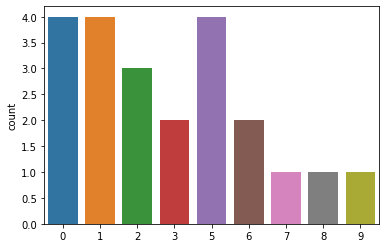

In [131]:
sns.countplot(predictions)
plt.title('Image_size=224')

Text(0.5, 1.0, 'Image_size=256')

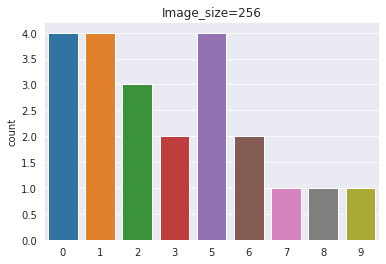

In [223]:
sns.countplot(predictions)
plt.title('Image_size=256')

In [224]:
len(predictions)

22

In [133]:
labels

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [225]:
label_dict = {k:v for k,v in enumerate(labels)}

In [226]:
label_dict

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spotted_spider_mite',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

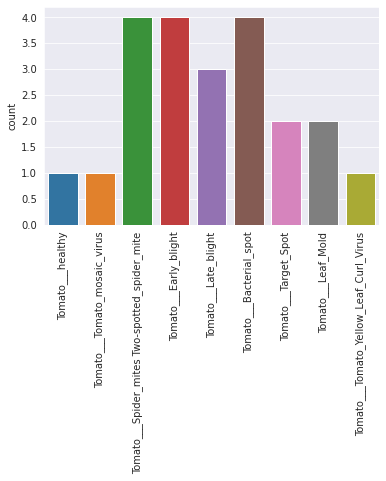

In [227]:
predicted_labels = [label_dict[x] for x in predictions]
sns.set_style('darkgrid')
plt.xticks(rotation =90)
sns.countplot(predicted_labels)

## Prediction 1 : Make predictions on arbitary images(Tomato Leaf)

In [228]:
from vit_keras import utils, visualize
img_path = "/content/drive/MyDrive/Tomato/tomato/train/Tomato___Early_blight/0208ed52-1b28-4c9c-88e3-4667581e1109___RS_Erly.B 7829.JPG"
image = utils.read(img_path, IMAGE_SIZE)

In [229]:
image.shape

(256, 256, 3)

In [230]:
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()])  

Prediction: Tomato___Early_blight


# Get an image and compute the attention map

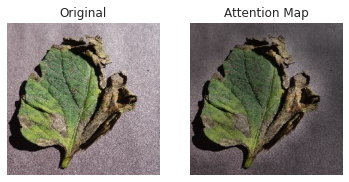

In [231]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## Prediction 2

## Making Predictions on an arbitary image fro internet 

In [232]:
url ="https://extension.umn.edu/sites/extension.umn.edu/files/styles/caption_medium/public/tomato-septoria-leaf-spot-grabowski.jpg?itok=iRHt-tr5"

In [233]:
image = utils.read(url, IMAGE_SIZE)
image.shape

(256, 256, 3)

In [234]:
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()])  

Prediction: Tomato___Early_blight


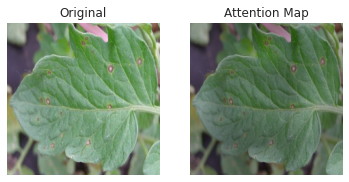

In [175]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## Prediction 3 

In [235]:
img_path = "/content/Healthy_tomato_leaf.jpg"
image = utils.read(img_path, IMAGE_SIZE)
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()])  

Prediction: Tomato___Early_blight


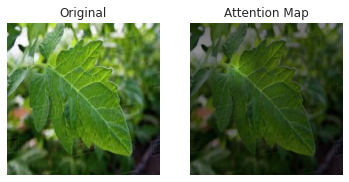

In [236]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## Prediction 4

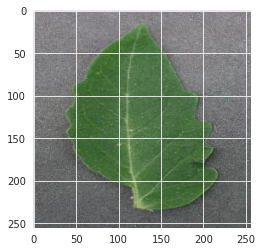

In [237]:
from PIL import Image
plt.imshow(Image.open("/content/drive/MyDrive/Tomato/tomato/train/Tomato___healthy/167247af-fd67-4b70-a72e-052dc5ea863b___GH_HL Leaf 388.1.JPG"))

In [238]:
img_path = "/content/drive/MyDrive/Tomato/tomato/train/Tomato___healthy/167247af-fd67-4b70-a72e-052dc5ea863b___GH_HL Leaf 388.1.JPG"
image = utils.read(img_path, IMAGE_SIZE)
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()])  

Prediction: Tomato___healthy


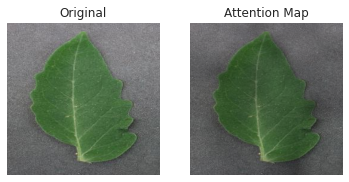

In [239]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

##Prediction 5

In [240]:
url ="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ825nkvaFVhUlDLZ1v0i-19bvdgpZw60raIg&usqp=CAU"
image = utils.read(url, IMAGE_SIZE)
print(image.shape)
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]) 

(256, 256, 3)
Prediction: Tomato___Late_blight


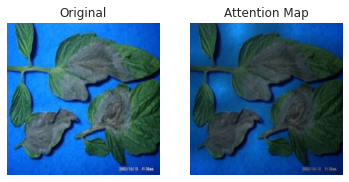

In [241]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## Predict 6

In [242]:
url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTyioEqkXP1oVHO0IMa9gY1Dy-aN9X0JcxUtw&usqp=CAU"
image = utils.read(url, IMAGE_SIZE)
print(image.shape)
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]) 

(256, 256, 3)
Prediction: Tomato___Late_blight


## compute the attention map of the image

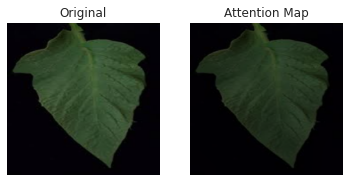

In [243]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## Prediction 7

In [244]:
url ="https://bloximages.chicago2.vip.townnews.com/journalstar.com/content/tncms/assets/v3/editorial/b/e1/be16edc4-71d7-5ff3-be84-da417edd8b96/5592c2e0b6df8.image.jpg"
image = utils.read(url, IMAGE_SIZE)
print(image.shape)
print('Prediction:', label_dict[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]) 

(256, 256, 3)
Prediction: Tomato___Septoria_leaf_spot


##Compute the attention map of the image

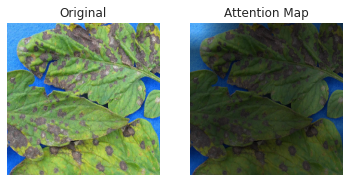

In [245]:
attention_map = visualize.attention_map(model=vit_model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

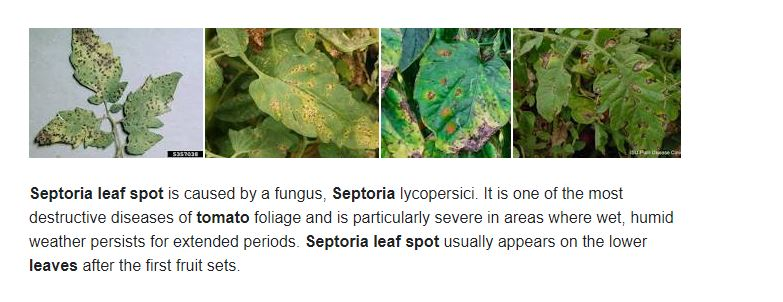

* The model was able to correctly detect the septorial leaf spot infection for prediction 7

## Training data for Tomato___Septoria_leaf_spot

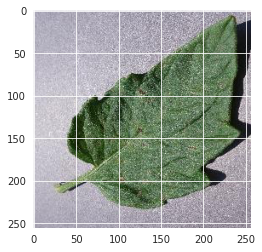

In [248]:
plt.imshow(Image.open("/content/drive/MyDrive/Tomato/tomato/train/Tomato___Septoria_leaf_spot/128693e3-7738-4185-802e-480a37afd497___Matt.S_CG 7673.JPG"))

## Referrences :

https://pypi.org/project/vit-keras/

https://www.kaggle.com/omar44ayaat/tomato-leaf-disease-detection-using-cnn

https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning

https://www.section.io/engineering-education/vision-transformer-using-transformers-for-image-recognition/

https://www.section.io/engineering-education/vision-transformer-using-transformers-for-image-recognition/